<a href="https://colab.research.google.com/github/theol0403/QMIND-CV-Robot-Vision/blob/main/Depth_map_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install deps { display-mode: "form" }
# Ensure TensorFlow is installed
%%capture
!pip install tensorflow

In [ ]:
# clone repo
import os

try:
    !git clone https://github.com/theol0403/QMIND-CV-Robot-Vision repo
except Exception as e:
    print(f"Error: {e}. Check if the repository exists and the module is in the correct location.")


Cloning into 'repo'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 118 (delta 47), reused 95 (delta 31), pack-reused 0
Receiving objects: 100% (118/118), 14.10 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
# Restart the runtime
# !reset -f

# Run the code again
# Standard library imports
import os
import sys

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Sequential
from keras import layers
import cv2
# Local application imports
sys.path.insert(1, 'repo/depth-map-project/')
from diode import DIODE

tf.random.set_seed(123)

# Constants
annotation_folder = "/val/"
split = 'val'
scene_type =  'indoors'
meta_fname = './repo/depth-map-project/diode_meta.json'
data_root = '/content/'
diode = DIODE(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root)

# Ensure annotation folder exists
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 65s 0us/step


In [ ]:
class CustomDataGenerator(Sequence):
    """
    CustomDataGenerator is a data generator class that generates batches of data for training or evaluation.

    Args:
        splits (list): List of splits to include in the data generator.
        scene_types (list): List of scene types to include in the data generator.
        meta_fname (str): File name of the metadata file.
        data_root (str): Root directory of the data.
        batch_size (int): Number of samples per batch.

    Attributes:
        batch_size (int): Number of samples per batch.
        diode (DIODE): DIODE object for loading and processing data.
        data_size (int): Total number of samples in the data generator.

    Methods:
        __len__(): Returns the number of batches in the data generator.
        __getitem__(index): Returns a batch of data at the given index.
        load(batch_id): Loads and preprocesses a single batch of data.
        data_generation(index): Generates a batch of data.

    """

    def __init__(self, splits, scene_types, meta_fname, data_root, batch_size, dim):
        self.batch_size = batch_size
        self.diode = DIODE(splits=splits, scene_types=scene_types, meta_fname=meta_fname, data_root=data_root)
        self.data_size = len(self.diode)
        self.dim = dim


    def __len__(self):
        """
        Returns the number of batches in the data generator.

        Returns:
            int: Number of batches.

        """
        return int(np.ceil(len(self.diode) / float(self.batch_size)))


    def __getitem__(self, index):
        """
        Returns a batch of data at the given index.

        Args:
            index (int): Index of the batch.

        Returns:
            tuple: A tuple containing the input data and target data.

        """
        load = self.data_generation(index)
        return  load

    def load(self, batch_id):
        """
        Loads and preprocesses a single batch of data.

        Args:
            batch_id (int): Index of the batch.

        Returns:
            tuple: A tuple containing the preprocessed input data, target data, and mask.

        """
        x, y, mask = self.diode[batch_id]

        x = cv2.resize(x, self.dim)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = tf.image.convert_image_dtype(x, tf.float32)

        mask = mask > 0

        temp = y.copy()
        max_depth = min(300, np.percentile(y, 99))
        if np.isnan(temp).any() or np.isinf(temp).any():
            print(f"After calculating percentile: min={temp.min()}, max={temp.max()}, mean={temp.mean()}, NaN count={np.isnan(temp).sum()}, Inf count={np.isinf(temp).sum()}")

        temp = max_depth
        max_depth = max(max_depth, 1)
        if np.isnan(temp):
            print(f"After ensuring max_depth is at least 1: max_depth={temp}, NaN={np.isnan(temp)}")

        temp = y.copy()
        y = np.clip(y, 0.1, max_depth)
        if np.isnan(temp).any() or np.isinf(temp).any():
            print(f"After clipping: min={temp.min()}, max={temp.max()}, mean={temp.mean()}, NaN count={np.isnan(temp).sum()}, Inf count={np.isinf(temp).sum()}")

        temp = y.copy()
        y = np.log(np.maximum(y, 0.001), where=mask)
        if np.isnan(y).any() or np.isinf(y).any():
            print(f"After log transformation: min={temp.min()}, max={temp.max()}, mean={temp.mean()}, NaN count={np.isnan(temp).sum()}, Inf count={np.isinf(temp).sum()}")
            y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
        y = np.ma.masked_where(~mask, y)

        y = np.clip(y, 0.1, np.log(max_depth))
        y = cv2.resize(y, self.dim)
        y = np.expand_dims(y, axis=2)
        y = tf.image.convert_image_dtype(y, tf.float32)

        return x, y

    def data_generation(self, index):
        """
        Generates a batch of data.

        Args:
            index (int): Index of the batch.

        Returns:
            tuple: A tuple containing the input data and target data.

        """
        x_batch, y_batch = [], []
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        for i in range(start_index, min(end_index + 1, self.data_size)):
            x, y = self.load(i)

            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)


        return x_batch, y_batch


In [ ]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p

class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x

class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


In [ ]:
class DepthMapModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)

def loss(target, pred):

    ssim_loss_weight = 0.85
    l1_loss_weight = 0.1
    edge_loss_weight = 0.9

    dy_true, dx_true = tf.image.image_gradients(target)
    dy_pred, dx_pred = tf.image.image_gradients(pred)
    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y

    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) index
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            target, pred, max_val=dim[0], filter_size=7, k1=0.01**2, k2=0.03**2
        )
    )
    # Point-wise depth
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (ssim_loss_weight * ssim_loss)
        + (l1_loss_weight * l1_loss)
        + (edge_loss_weight * depth_smoothness_loss)
    )

    return loss

model = DepthMapModel()

#define hyperparameters
batch_size = 28
epochs = 20
dim = (256, 256)
lr = 0.0002

model.compile(optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr), loss=loss, metrics=['accuracy'])

custom_data_generator = CustomDataGenerator(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root, batch_size=batch_size, dim=dim)


# Check if GPU is available
if not tf.config.list_physical_devices('GPU'):
    print("Warning: No GPU detected. Training may be slow.")

model.fit(custom_data_generator , epochs=epochs)



Epoch 1/20
8/8 [==============================] - 46s 3s/step - loss: 0.8041 - accuracy: 1.0500e-04
Epoch 2/20
8/8 [==============================] - 15s 2s/step - loss: 0.5720 - accuracy: 5.1423e-05
Epoch 3/20
8/8 [==============================] - 15s 2s/step - loss: 0.4686 - accuracy: 1.6744e-04
Epoch 4/20
8/8 [==============================] - 17s 2s/step - loss: 0.4011 - accuracy: 1.4553e-04
Epoch 5/20
8/8 [==============================] - 15s 2s/step - loss: 0.3672 - accuracy: 1.2920e-04
Epoch 6/20
8/8 [==============================] - 15s 2s/step - loss: 0.3505 - accuracy: 2.3722e-04
Epoch 7/20
8/8 [==============================] - 16s 2s/step - loss: 0.3341 - accuracy: 1.8102e-04
Epoch 8/20
8/8 [==============================] - 16s 2s/step - loss: 0.3206 - accuracy: 1.9198e-04
Epoch 9/20
8/8 [==============================] - 16s 2s/step - loss: 0.3102 - accuracy: 1.6852e-04
Epoch 10/20
8/8 [==============================] - 15s 2s/step - loss: 0.3026 - accuracy: 1.0278e-04

1/1 [==============================] - 0s 22ms/step


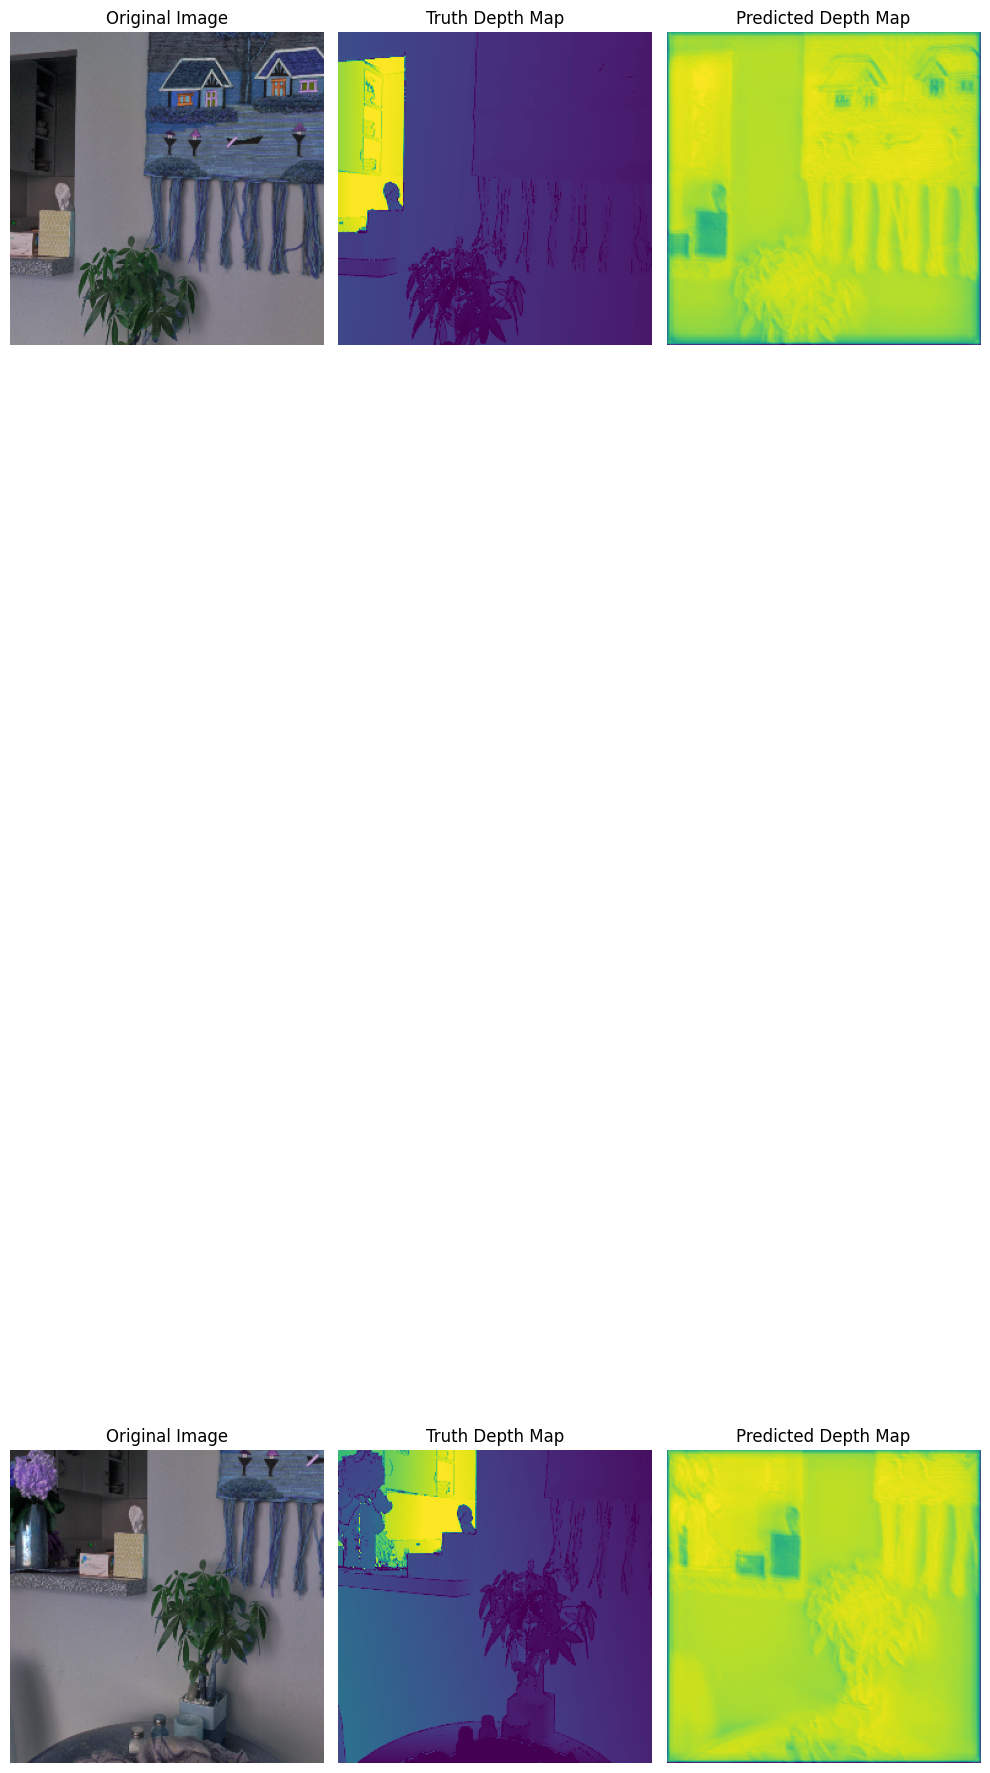

In [ ]:
num_tests = 2

fig, axs = plt.subplots(nrows=num_tests, ncols=3, figsize=(10, 20*num_tests))  # Adjust as needed

# fig, axs = plt.subplots(nrows=100, ncols=3, figsize=(10, 20*num_tests))  # Adjust as needed

# Load and predict 5 images
for i in range(num_tests):
    custom_data_generator = CustomDataGenerator(splits=split, scene_types=scene_type, meta_fname=meta_fname, data_root=data_root, batch_size=1, dim=dim)
    x, y = custom_data_generator.load(i+108)

    x = np.expand_dims(x, axis=0)

    # Predict depth map
    y_pred = model.predict(x)

    # Plot original image, truth depth map, and predicted depth map using matplotlib
    axs[i, 0].imshow(x[0])
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(y)
    axs[i, 1].set_title('Truth Depth Map')
    axs[i, 2].imshow(y_pred[0, :, :, 0])
    axs[i, 2].set_title('Predicted Depth Map')

# Remove axis for all subplots
for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()